In [18]:
import torch
from torch import nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

mpl.rcParams['animation.ffmpeg_path'] = '/Users/joshuapark/Documents/ffmpeg'

#from util import rmse, rmse_by_month, plot_mean_errors, animate_predictions, animate_residuals

In [19]:
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.animation as animation
from sklearn.metrics import mean_squared_error

countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))

def rmse(y_true, y_pred, labels,weighted=True):
    if weighted:
        weight = np.cos(labels["lat"].values * np.pi / 180)
    else:
        weight=None
    return mean_squared_error(
        y_true, y_pred, sample_weight=weight,
        squared=False
    )


def rmse_by_month(y_true, y_pred, labels,weighted=True):
    if weighted:
        weight = np.cos(labels["lat"].values * np.pi / 180)
    else:
        weight=None
    return mean_squared_error(
        y_true, y_pred, sample_weight=weight,
        squared=False,multioutput="raw_values"
    )



def plot_mean_errors(y_true, y_pred, labels, title, figsize=(20,6)):
    """
    *y_true* is be a numpy array of shape (6, n)
    *y_pred* is be a numpy array of shape (6, n)
    *labels* is a pandas dataframe containing the latitude 
         and longitude values for each row of *y_true* and *y_pred*
    """
    
    err = (y_pred - y_true).mean(axis=1)

    err_df = labels.copy()
    err_df["err"] = err

    mean_errs = err_df.groupby(["lon", "lat"]).mean().reset_index()
    
    # set up latlongs for pcolormesh
    lons = labels.lon.unique()
    lons.sort()
    
    lats = labels.lat.unique()
    lats.sort()
    
    lats = np.vstack([lats] * len(lons))
    lons = np.vstack([lons] * lats.shape[1]).T
    
    errs = mean_errs.err.values.reshape(lats.shape)
    
    # initialize an axis
    fig, ax = plt.subplots(figsize=figsize)

    
    norm = TwoSlopeNorm(vcenter=0)
    c = plt.pcolormesh(lons, lats, errs,
                       norm=norm,
                   cmap='RdBu_r', 
                   shading='gouraud')
    plt.colorbar(c)
    
    countries.geometry.boundary.plot(
        color=None,edgecolor='gray',linewidth = 2,ax=ax)    
    
    ax.set_ylim(-60, 60)
    ax.set_title(title)
    
    return(err_df, mean_errs)


def animate_predictions(y_true, y_pred, labels, filename,
                        lags=list(range(1,7))):
    """
    y_true: numpy array of shape (n x 6) containing the true
            temperature values of the horizon in chronological
            order.  Column 0 is 1 month after the end of the 
            context, column 1 is 2 months after, etc.
    y_true: numpy array of shape (n x 6) containing the predicted
            temperature values of the horizon in chronological
            order.  Column 0 is 1 month after the end of the 
            context, column 1 is 2 months after, etc.
    labels: pd.DataFrame with columns ["lon", "lat", "date"].  
                NOTE: Each row of labels must match y_true and y_pred
    lags: Time lags between context and prediction to use in animation.
                With a six-month horizon possible lags are 1 through 6.
    filename: must be ".mov", ".avi" or ".mp4"
    """
    # set up the information required for animation
    month_offset = labels.groupby("date").lon.count().iloc[0]
    dates = labels.date.unique()
    horizon = y_true.shape[1]
    
    # save all predictions in a new DataFrame
    # lag columns must be realigned so that the
    # predictions for a fixed date are in the same
    # column, rather than the predictions from a
    # fixed context.
    tmp = labels.copy()
    tmp["T"] = y_true[:, -1]
    
    keys = []
    for lag in lags:
        key = f"pred_lag_{lag}"
        keys.append(key)
        
        # columns indices are off by 1
        # since column 0 has a 1-month lag
        # and column 5 has a 6-month lag
        tmp[key] = y_pred[:, lag-1]
        
        # The six-month lag prediction is aligned
        # with "T" in the initial DataFrame.  The five-month
        # lag is one month back, the four-month lag is
        # two months back, etc.
        tmp[key] = tmp[key].shift((lag-horizon) * month_offset)
        
    # set up values and latlongs for pcolormesh
    # insure that all values are in the same order.
    tmp.sort_values(["date", "lon", "lat"], inplace=True)

    lons = labels.lon.unique()
    lons.sort()
    
    lats = labels.lat.unique()
    lats.sort()
    
    lats = np.vstack([lats] * len(lons))
    lons = np.vstack([lons] * lats.shape[1]).T
    
    # setup plot for the animation
    n_axes = len(lags) + 1
    fig, ax = plt.subplots(n_axes, 1, figsize=(20,6 * n_axes))
    
    # starting data for first frame
    T = tmp[tmp.date == dates[0]]["T"].values.reshape(lons.shape)
    
    lag_preds = [
        tmp[tmp.date == dates[0]][key].values.reshape(lons.shape)
        for key in keys
    ]
    
    # compute min and max values for colorbars
    # so they remain consistent across all frames
    vmin = np.nanmin(tmp[tmp.columns[3:]].values)
    vmax = np.nanmax(tmp[tmp.columns[3:]].values)
    
    # initialize colormaps for first frame
    cmesh_T = ax[0].pcolormesh(lons, lats, T, vmin=vmin, 
                       vmax=vmax, cmap='RdBu_r', shading='gouraud')
    
    # use ax[i + 1] since ax[0] contains the true temperatures.
    cmesh_lags = [
        ax[i+1].pcolormesh(lons, lats, lag_preds[i], 
                           vmin=vmin, vmax=vmax, cmap='RdBu_r', 
                           shading='gouraud')
        for i in range(len(lags))
    ]
    
    # plot outlines of countries on all subplots
    for i in range(n_axes):
        countries.geometry.boundary.plot(
                        color=None,edgecolor='gray',linewidth = 2,ax=ax[i])  
        ax[i].set_ylim(-60, 60)
        fig.colorbar(cmesh_T, ax=ax[i])
        
    # This function creates the ith frame
    # of the animation
    def animate(i):
        filtered = tmp[tmp.date == dates[i]]
        
        # update true temperature colormesh
        T = filtered["T"].values.reshape(lons.shape)
        cmesh_T.set_array(T)
        ax[0].set_title(f"Observed temperatures: {dates[i]}")
        
        # update predicted temperature colormeshes
        for j, key in enumerate(keys):
            pred = filtered[key].values.reshape(lons.shape)
            cmesh_lags[j].set_array(pred)
            # index is off by 1 since first subplot
            # contains the observed temperatures
            ax[j + 1].set_title(f"{key}: {dates[i]}")

    # write animation
    anim = animation.FuncAnimation(fig, animate, interval=500,
                                   frames=len(dates))
    writervideo = animation.FFMpegWriter(fps=2) 
    anim.save(filename, writer=writervideo)
    
    

def animate_residuals(y_true, y_pred, labels, filename,
                        lags=list(range(1,7))):
    """
    y_true: numpy array of shape (n x 6) containing the true
            temperature values of the horizon in chronological
            order.  Column 0 is 1 month after the end of the 
            context, column 1 is 2 months after, etc.
    y_true: numpy array of shape (n x 6) containing the predicted
            temperature values of the horizon in chronological
            order.  Column 0 is 1 month after the end of the 
            context, column 1 is 2 months after, etc.
    labels: pd.DataFrame with columns ["lon", "lat", "date"].  
                NOTE: Each row of labels must match y_true and y_pred
    lags: Time lags between context and prediction to use in animation.
                With a six-month horizon possible lags are 1 through 6.
    filename: must be ".mov", ".avi" or ".mp4"
    """
    # set up the information required for animation
    month_offset = labels.groupby("date").lon.count().iloc[0]
    dates = labels.date.unique()
    horizon = y_true.shape[1]
    
    # save all predictions in a new DataFrame
    # lag columns must be realigned so that the
    # predictions for a fixed date are in the same
    # column, rather than the predictions from a
    # fixed context.
    tmp = labels.copy()
    tmp["T"] = y_true[:, -1]
    
    keys = []
    for lag in lags:
        key = f"pred_lag_{lag}"
        keys.append(key)
        
        # columns indices are off by 1
        # since column 0 has a 1-month lag
        # and column 5 has a 6-month lag
        tmp[key] = y_pred[:, lag-1]
        
        # The six-month lag prediction is aligned
        # with "T" in the initial DataFrame.  The five-month
        # lag is one month back, the four-month lag is
        # two months back, etc.
        tmp[key] = tmp[key].shift((lag - horizon) * month_offset)
        
    # set up values and latlongs for pcolormesh
    # insure that all values are in the same order.
    tmp.sort_values(["date", "lon", "lat"], inplace=True)

    lons = labels.lon.unique()
    lons.sort()
    
    lats = labels.lat.unique()
    lats.sort()
    
    lats = np.vstack([lats] * len(lons))
    lons = np.vstack([lons] * lats.shape[1]).T
    
    # setup plot for the animation
    n_axes = len(lags)
    fig, ax = plt.subplots(n_axes, 1, figsize=(20,6 * n_axes))
    
    # starting data for first frame
    T = tmp[tmp.date == dates[0]]["T"].values.reshape(lons.shape)
    
    lag_preds = [
        tmp[tmp.date == dates[0]][key].values.reshape(lons.shape)
        for key in keys
    ]
    
    # compute min and max values for colorbars
    # so they remain consistent across all frames
    pred_values = tmp[tmp.columns[4:]].values
    true_values = np.vstack([tmp["T"]] * len(lags)).T
    all_residuals = (pred_values - true_values) / pred_values
    vmin = np.nanmin(all_residuals)
    vmax = np.nanmax(all_residuals)
    
    # setup the initial pcolormesh
    cmesh_lags = [
        ax[i].pcolormesh(lons, lats, lag_preds[i] - T, 
                           vmin=vmin, vmax=vmax, cmap='RdBu_r', 
                           shading='gouraud')
        for i in range(len(lags))
    ]
    
    # plot outlines of countries on all subplots
    for i in range(n_axes):
        countries.geometry.boundary.plot(
                        color=None,edgecolor='gray',linewidth = 2,ax=ax[i])  
        ax[i].set_ylim(-60, 60)
        fig.colorbar(cmesh_lags[0], ax=ax[i])
        
    # This function creates the ith frame
    # of the animation
    def animate(i):
        filtered = tmp[tmp.date == dates[i]]

        # update true temperature colormesh
        T = filtered["T"].values.reshape(lons.shape)
        
        # update predicted temperature colormeshes
        for j, key in enumerate(keys):
            pred = filtered[key].values.reshape(lons.shape)
            cmesh_lags[j].set_array((pred - T) / pred)
            # index is off by 1 since first subplot
            # contains the observed temperatures
            ax[j].set_title(f"{key} residuals: {dates[i]}")

    # write animation
    anim = animation.FuncAnimation(fig, animate, interval=500,
                                   frames=len(dates))
    writervideo = animation.FFMpegWriter(fps=2) 
    anim.save(filename, writer=writervideo)

In [20]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
%autoreload 2

In [22]:
df = pd.read_csv('Strat_Temp_AOD_Flux.csv')
df.head()

lon   lat           T       AOD      SWTNT       LWTUP     TOTFLUX  \
0 -176.5625  56.5  229.257093  0.125594  29.557358  205.312817 -175.755460   
1 -169.0625  56.5  229.008780  0.111849  29.239552  205.364511 -176.124959   
2 -161.5625  56.5  228.609150  0.099602  28.665446  201.603913 -172.938468   
3 -154.0625  56.5  227.929692  0.100677  29.080268  202.826532 -173.746264   
4 -146.5625  56.5  226.916581  0.135423  28.714139  199.891219 -171.177081   

         date  lev  month  year  day  
0  1986-01-01   50      1  1986    0  
1  1986-01-01   50      1  1986    0  
2  1986-01-01   50      1  1986    0  
3  1986-01-01   50      1  1986    0  
4  1986-01-01   50      1  1986    0

In [23]:
#Extract lat, lon, and dates
lon_vals = df['lon'].unique()
lat_vals = df['lat'].unique()
dates = df['date'].unique()
print(lon_vals)
print(lat_vals)
print(len(dates))

[-176.5625 -169.0625 -161.5625 -154.0625 -146.5625 -139.0625 -131.5625
 -124.0625 -116.5625 -109.0625 -101.5625  -94.0625  -86.5625  -79.0625
  -71.5625  -64.0625  -56.5625  -49.0625  -41.5625  -34.0625  -26.5625
  -19.0625  -11.5625   -4.0625    3.4375   10.9375   18.4375   25.9375
   33.4375   40.9375   48.4375   55.9375   63.4375   70.9375   78.4375
   85.9375   93.4375  100.9375  108.4375  115.9375  123.4375  130.9375
  138.4375  145.9375  153.4375  160.9375  168.4375  175.9375]
[ 56.5  49.   41.5  34.   26.5  19.   11.5   4.   -3.5 -11.  -18.5 -26.
 -33.5 -41.  -48.5 -56. ]
120


In [24]:
#Create 16x48x120 tensor for Temperature data
data_tot = torch.empty(size=(16,48,120))
data_tot_AOD = torch.empty(size=(16,48,120))
data_tot_SW = torch.empty(size=(16,48,120))
data_tot_LW = torch.empty(size=(16,48,120))
data_tot_flux = torch.empty(size=(16,48,120))
for i in range(len(lat_vals)):
    for j in range(len(lon_vals)):
        temp = df[(df['lat'] == lat_vals[i]) & (df['lon'] == lon_vals[j])]
        data_tot[i,j,:] = torch.from_numpy(np.array(temp['T'])).float()
        data_tot_AOD[i,j,:] = torch.from_numpy(np.array(temp['AOD'])).float()
        data_tot_SW[i,j,:] = torch.from_numpy(np.array(temp['SWTNT'])).float()
        data_tot_LW[i,j,:] = torch.from_numpy(np.array(temp['LWTUP'])).float()
        data_tot_flux[i,j,:] = torch.from_numpy(np.array(temp['TOTFLUX'])).float()
#data_tot contains all the temperatures from all spatial points (16x48) with 120 time steps
#data_tot_AOD contains all AOD values from all spatial points (16x48) with 120 time steps

In [25]:
def sliding_window(dates, data, seq_len, out_len): #Creates sliding window and normalizes X-values
    x, y, start_dates = [], [], []
    
    for j in range(len(data[0,0]) - seq_len - out_len): #create sliding windows
        _x = data[:,:,j:(j+seq_len)]
        _y = data[:,:, (j+seq_len):(j+seq_len+out_len)]
        x_date = dates[j]
        y_date = dates[j+seq_len]
        x.append(_x)
        y.append(_y)
        start_dates.append((x_date, y_date))
    #Normalize
    x = np.array(x)
    xmax = x.max()
    xmin = x.min()
    x_norm = (x - xmin) / (xmax - xmin)
    return start_dates, x_norm, np.array(y)

In [26]:
#Training set A contains first 38 time steps
#Training set B contains first 49 time steps
sequence_len = 24
output_len = 6
x_start_dates, x_tot, y_tot =  sliding_window(dates, np.array(data_tot), sequence_len, output_len)
#y_start_dates, x_test_tot, y_test_tot = sliding_window(dates, np.array(data_tot), sequence_len, output_len)

x_start_dates_AOD, x_tot_AOD, y_tot_AOD = sliding_window(dates, np.array(data_tot_AOD), sequence_len, output_len)
#y_start_dates_AOD, x_test_tot_AOD, y_test_tot_AOD = sliding_window(dates, np.array(data_tot_AOD), sequence_len, output_len)

x_start_dates_SW, x_tot_SW, y_tot_SW =  sliding_window(dates, np.array(data_tot_SW), sequence_len, output_len)
x_start_dates_LW, x_tot_LW, y_tot_LW =  sliding_window(dates, np.array(data_tot_LW), sequence_len, output_len)
x_start_dates_flux, x_tot_flux, y_tot_flux =  sliding_window(dates, np.array(data_tot_flux), sequence_len, output_len)

#x_train_B, y_train_B =  sliding_window(np.array(data_tot[:,:,:72]), sequence_len, output_len)
#x_test_B, y_test_B = sliding_window(np.array(data_tot[:,:,72:]), sequence_len, output_len)

#x_train_B_AOD, y_train_B_AOD = sliding_window(np.array(data_tot_AOD[:,:,:72]), sequence_len, output_len)
#x_test_B_AOD, y_test_B_AOD = sliding_window(np.array(data_tot_AOD[:,:,72:]), sequence_len, output_len)

In [27]:
print(x_start_dates[31])
print(x_start_dates[42])

('1988-08-01', '1990-08-01')
('1989-07-01', '1991-07-01')


In [28]:
#Grab training set A x temperatures
x_train_A = torch.from_numpy(x_tot[:31,:,:,:])

#Grab training set A x AODs 
x_train_A_AOD = torch.from_numpy(x_tot_AOD[:31,:,:,:])
x_train_A_AOD = torch.cat([x_train_A, x_train_A_AOD], 3)

#Grab training set A x SW
x_train_A_SW = torch.from_numpy(x_tot_SW[:31,:,:,:])
x_train_A_SW = torch.cat([x_train_A, x_train_A_SW], 3)

#Grab training set A x LW
x_train_A_LW = torch.from_numpy(x_tot_LW[:31,:,:,:])
x_train_A_LW = torch.cat([x_train_A, x_train_A_LW], 3)

#Grab training set A x total flux
x_train_A_flux = torch.from_numpy(x_tot_flux[:31,:,:,:])
x_train_A_flux = torch.cat([x_train_A, x_train_A_flux], 3)

#Test with Gaussian noise
x_train_A_noise = torch.from_numpy(np.random.normal(0,1, (31, 16, 48, 24)))
x_train_A_noise = torch.cat([x_train_A, x_train_A_noise], 3)

#Concatenate the temperature and AOD tensors on the time dimension (d=0)
#y_train_A_AOD = torch.cat([torch.from_numpy(y_tot[:31,:,:,:]), torch.from_numpy(y_tot_AOD[:31,:,:,:])], 0)
y_train_A = torch.from_numpy(y_tot[:31,:,:,:])

#Grab training set B x temperatures
x_train_B = torch.from_numpy(x_tot[:42,:,:,:])

#Grab training set B x AODs
x_train_B_AOD = torch.from_numpy(x_tot_AOD[:42,:,:,:])
x_train_B_AOD = torch.cat([x_train_B, x_train_B_AOD], 3)

#Grab training set B x SW
x_train_B_SW = torch.from_numpy(x_tot_SW[:42,:,:,:])
x_train_B_SW = torch.cat([x_train_B, x_train_B_SW], 3)

#Grab training set B x LW
x_train_B_LW = torch.from_numpy(x_tot_LW[:42,:,:,:])
x_train_B_LW = torch.cat([x_train_B, x_train_B_LW], 3)

#Grab training set B x total flux
x_train_B_flux = torch.from_numpy(x_tot_flux[:42,:,:,:])
x_train_B_flux = torch.cat([x_train_B, x_train_B_flux], 3)

#Concatenate the temperature and AOD tensors on the time dimension (d=0)
#y_train_B_AOD = torch.cat([torch.from_numpy(y_tot[:42,:,:,:]), torch.from_numpy(y_tot_AOD[:42,:,:,:])], 0)
y_train_B = torch.from_numpy(y_tot[:42,:,:,:])

In [29]:
#Grab test set A x temperatures
x_test_A = torch.from_numpy(x_tot[31:,:,:,:])

#Grab test set A x AODs
x_test_A_AOD = torch.from_numpy(x_tot_AOD[31:,:,:,:])
x_test_A_AOD = torch.cat([x_test_A, x_test_A_AOD], 3)

#Grab test set A x SW
x_test_A_SW = torch.from_numpy(x_tot_SW[31:,:,:,:])
x_test_A_SW = torch.cat([x_test_A, x_test_A_SW], 3)

#Grab test set A x LW
x_test_A_LW = torch.from_numpy(x_tot_LW[31:,:,:,:])
x_test_A_LW = torch.cat([x_test_A, x_test_A_LW], 3)

#Grab test set A x total flux
x_test_A_flux = torch.from_numpy(x_tot_flux[31:,:,:,:])
x_test_A_flux = torch.cat([x_test_A, x_test_A_flux], 3)

#Test with Gaussian noise
x_test_A_noise = torch.from_numpy(np.random.normal(0,1, (59, 16, 48, 24)))
x_test_A_noise = torch.cat([x_test_A, x_test_A_noise], 3)

#Concatenate the temperature and AOD tensors on the time dimension (d=0)
#y_test_A_AOD = torch.cat([torch.from_numpy(y_tot[31:,:,:,:]), torch.from_numpy(y_tot_AOD[31:,:,:,:])], 0)
y_test_A = torch.from_numpy(y_tot[31:,:,:,:])

#Grab training set B x temperatures and normalize
x_test_B = torch.from_numpy(x_tot[42:,:,:,:])

#Grab training set B x AODs
x_test_B_AOD = torch.from_numpy(x_tot_AOD[42:,:,:,:])
x_test_B_AOD = torch.cat([x_test_B, x_test_B_AOD], 3)

#Grab training set B x SW
x_test_B_SW = torch.from_numpy(x_tot_SW[42:,:,:,:])
x_test_B_SW = torch.cat([x_test_B, x_test_B_SW], 3)

#Grab training set B x LW
x_test_B_LW = torch.from_numpy(x_tot_LW[42:,:,:,:])
x_test_B_LW = torch.cat([x_test_B, x_test_B_LW], 3)

#Grab training set B x total flux
x_test_B_flux = torch.from_numpy(x_tot_flux[42:,:,:,:])
x_test_B_flux = torch.cat([x_test_B, x_test_B_flux], 3)

#Concatenate the temperature and AOD tensors on the time dimension (d=0)
#y_test_B_AOD = torch.cat([torch.from_numpy(y_tot[42:,:,:,:]), torch.from_numpy(y_tot_AOD[42:,:,:,:])], 0)
y_test_B = torch.from_numpy(y_tot[42:,:,:,:])

In [30]:
train_dates_A = x_start_dates[:31]
test_dates_A = x_start_dates[31:]
train_dates_B = x_start_dates[:42]
test_dates_B = x_start_dates[42:]

In [31]:
#We must convert the dimensions to [1, number of time steps, 16,48]
x_train_A = torch.permute(x_train_A, (0,3,1,2))
y_train_A = torch.permute(y_train_A, (0,3,1,2))
x_train_A_AOD = torch.permute(x_train_A_AOD, (0,3,1,2))
x_train_A_SW = torch.permute(x_train_A_SW, (0,3,1,2))
x_train_A_LW = torch.permute(x_train_A_LW, (0,3,1,2))
x_train_A_flux = torch.permute(x_train_A_flux, (0,3,1,2))

x_train_A_noise = torch.permute(x_train_A_noise, (0,3,1,2))
#y_train_A_AOD = torch.permute(y_train_A_AOD, (0,3,1,2))

x_train_B = torch.permute(x_train_B, (0,3,1,2))
y_train_B = torch.permute(y_train_B, (0,3,1,2))
x_train_B_AOD = torch.permute(x_train_B_AOD, (0,3,1,2))
x_train_B_SW = torch.permute(x_train_B_SW, (0,3,1,2))
x_train_B_LW = torch.permute(x_train_B_LW, (0,3,1,2))
x_train_B_flux = torch.permute(x_train_B_flux, (0,3,1,2))
#y_train_B_AOD = torch.permute(y_train_B_AOD, (0,3,1,2))

x_test_A = torch.permute(x_test_A, (0,3,1,2))
y_test_A = torch.permute(y_test_A, (0,3,1,2))
x_test_A_AOD = torch.permute(x_test_A_AOD, (0,3,1,2))
x_test_A_SW = torch.permute(x_test_A_SW, (0,3,1,2))
x_test_A_LW = torch.permute(x_test_A_LW, (0,3,1,2))
x_test_A_flux = torch.permute(x_test_A_flux, (0,3,1,2))

x_test_A_noise = torch.permute(x_test_A_noise, (0,3,1,2))
#y_test_A_AOD = torch.permute(y_test_A_AOD, (0,3,1,2))

x_test_B = torch.permute(x_test_B, (0,3,1,2))
y_test_B = torch.permute(y_test_B, (0,3,1,2))
x_test_B_AOD = torch.permute(x_test_B_AOD, (0,3,1,2))
x_test_B_SW = torch.permute(x_test_B_SW, (0,3,1,2))
x_test_B_LW = torch.permute(x_test_B_LW, (0,3,1,2))
x_test_B_flux = torch.permute(x_test_B_flux, (0,3,1,2))
#y_test_B_AOD = torch.permute(y_test_B_AOD, (0,3,1,2))

In [32]:
#Convert all sets to list of 16x48xtime tensors!!
def list_of_tensors(tensor):
    list_tensor = []
    for i in range(len(tensor)):
        list_tensor.append(tensor[i])
    return list_tensor

In [33]:
#For the input to the CNN we must get a list of tensors size (1,time_steps,16,48)
x_train_A = list_of_tensors(x_train_A)
y_train_A = list_of_tensors(y_train_A)
x_train_A_AOD = list_of_tensors(x_train_A_AOD)
x_train_A_SW = list_of_tensors(x_train_A_SW)
x_train_A_LW = list_of_tensors(x_train_A_LW)
x_train_A_flux = list_of_tensors(x_train_A_flux)

x_train_A_noise = list_of_tensors(x_train_A_noise)
#y_train_A_AOD = list_of_tensors(y_train_A_AOD)

x_train_B = list_of_tensors(x_train_B)
y_train_B = list_of_tensors(y_train_B)
x_train_B_AOD = list_of_tensors(x_train_B_AOD)
x_train_B_SW = list_of_tensors(x_train_B_SW)
x_train_B_LW = list_of_tensors(x_train_B_LW)
x_train_B_flux = list_of_tensors(x_train_B_flux)

#y_train_B_AOD = list_of_tensors(y_train_B_AOD)

x_test_A = list_of_tensors(x_test_A)
y_test_A = list_of_tensors(y_test_A)
x_test_A_AOD = list_of_tensors(x_test_A_AOD)
x_test_A_SW = list_of_tensors(x_test_A_SW)
x_test_A_LW = list_of_tensors(x_test_A_LW)
x_test_A_flux = list_of_tensors(x_test_A_flux)

x_test_A_noise = list_of_tensors(x_test_A_noise)
#y_test_A_AOD = list_of_tensors(y_test_A_AOD)

x_test_B = list_of_tensors(x_test_B)
y_test_B = list_of_tensors(y_test_B)
x_test_B_AOD = list_of_tensors(x_test_B_AOD)
x_test_B_SW = list_of_tensors(x_test_B_SW)
x_test_B_LW = list_of_tensors(x_test_B_LW)
x_test_B_flux = list_of_tensors(x_test_B_flux)
#y_test_B_AOD = list_of_tensors(y_test_B_AOD)

In [90]:
print(x_train_A[0].shape)
print(x_train_A_AOD[0].shape)
print(len(x_train_A))
print(len(x_train_B))

torch.Size([24, 16, 48])
torch.Size([48, 16, 48])
31
42


In [35]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        #24 in-channels for context, 6 out-channels for horizon, kernel size 3x3
        self.conv1 = nn.Conv2d(24, 6, 3, padding='same') 
        #self.conv2 = nn.Conv2d(24, 6, 3, padding='same')
    
    def forward(self, x):
        x = self.conv1(x)
        return x

In [36]:
def weighted_RMSE(output, target):
    lat_weights = [ 0.98611103,  0.85521133,  0.72431164,  0.59341195,  0.46251225,
        0.33161256,  0.20071286,  0.06981317, -0.06108652, -0.19198622,
       -0.32288591, -0.45378561, -0.5846853 , -0.71558499, -0.84648469,
       -0.97738438] #Latitudes converted to radians
    loss = torch.mean(torch.mul((output - target)**2, torch.tensor(np.cos(lat_weights))[:,None]))
    return torch.sqrt(loss)

In [38]:
#Training loop for training set A Temperature only
n_epochs = 10000
learning_rate = 1e-3

cnn = CNN()
#criterion = weighted_RMSE()
optimizer = optim.Adam(cnn.parameters(), lr = learning_rate)

for i in range(n_epochs):
    avg_loss = 0
    for j in range(len(x_train_A)):
        cnn.train()
        outputs = cnn(x_train_A[j])
        optimizer.zero_grad()
    
        loss = weighted_RMSE(outputs, y_train_A[j])
        avg_loss += loss
        loss.backward()
    
        optimizer.step()
    avg_loss = avg_loss/len(x_train_A)
    avg_loss_test = 0
    for k in range(len(x_test_A)):
        cnn.eval()
        valid = cnn(x_test_A[k])
        test_loss = weighted_RMSE(valid, y_test_A[k])
        avg_loss_test += test_loss
    avg_loss_test = avg_loss_test/len(x_test_A)
    if i %500 == 0 or i == n_epochs-1:
        print("Epoch: %d, loss: %1.5f test loss:  %1.5f " %(i, avg_loss , avg_loss_test))

Epoch: 0, loss: 191.40414 test loss:  190.19594 
Epoch: 500, loss: 46.31739 test loss:  44.68279 
Epoch: 1000, loss: 41.69309 test loss:  41.33116 
Epoch: 1500, loss: 37.69383 test loss:  38.19920 
Epoch: 2000, loss: 33.94011 test loss:  34.99758 
Epoch: 2500, loss: 30.30020 test loss:  31.67855 
Epoch: 3000, loss: 26.72653 test loss:  28.25734 
Epoch: 3500, loss: 23.20136 test loss:  24.75926 
Epoch: 4000, loss: 19.71896 test loss:  21.20784 
Epoch: 4500, loss: 16.28059 test loss:  17.62428 
Epoch: 5000, loss: 12.89424 test loss:  14.03020 
Epoch: 5500, loss: 9.58162 test loss:  10.45584 
Epoch: 6000, loss: 6.40091 test loss:  6.96289 
Epoch: 6500, loss: 3.56409 test loss:  3.76606 
Epoch: 7000, loss: 1.94412 test loss:  1.89818 
Epoch: 7500, loss: 1.68745 test loss:  1.71605 
Epoch: 8000, loss: 1.63274 test loss:  1.71465 
Epoch: 8500, loss: 1.60456 test loss:  1.71791 
Epoch: 9000, loss: 1.58722 test loss:  1.72337 
Epoch: 9500, loss: 1.57563 test loss:  1.72951 
Epoch: 9999, loss: 

In [77]:
PATH = '/Users/joshuapark/Documents/Data_Science/Graduate/SandiaProject/cnn_trainsetA_kernel3x3_temp'
torch.save(cnn.state_dict(), PATH)

In [39]:
y_pred_A = []
for i in range(5, 41):
    new_pred = cnn(x_test_A[i])
    y_pred_A.append(new_pred)

In [40]:
len(test_dates_A[5:41])

36

In [41]:
new_pred = torch.empty(6,27648)
true_vals = torch.empty(6,27648)
index = int(0)

for k in range(36):
    for i in range(len(lat_vals)): #Latitudes
        for j in range(len(lon_vals)): #Longitudes
            new_pred[:,index] = y_pred_A[k][:,i,j] #Change array shape for animations
            true_vals[:,index] = y_test_A[k][:,i,j]
            index += 1
new_pred = new_pred.detach()
true_vals = true_vals.detach()
new_pred = np.array(new_pred)
true_vals = np.array(true_vals)
new_pred = np.transpose(new_pred)
true_vals = np.transpose(true_vals)

In [42]:
#Create the test labels for the animations/plots
new_df = pd.read_csv("df_trains_ctx.csv")
test_A_labels = new_df[new_df.Test_A][["lon", "lat", "date"]]
test_B_labels = new_df[new_df.Test_B][["lon", "lat", "date"]]

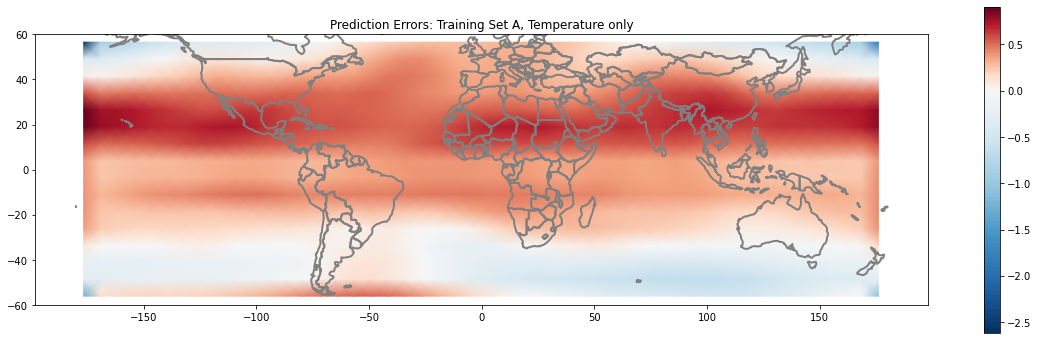

In [43]:
_ = plot_mean_errors(
    true_vals,
    new_pred,
    test_A_labels,
    "Prediction Errors: Training Set A, Temperature only"
    )

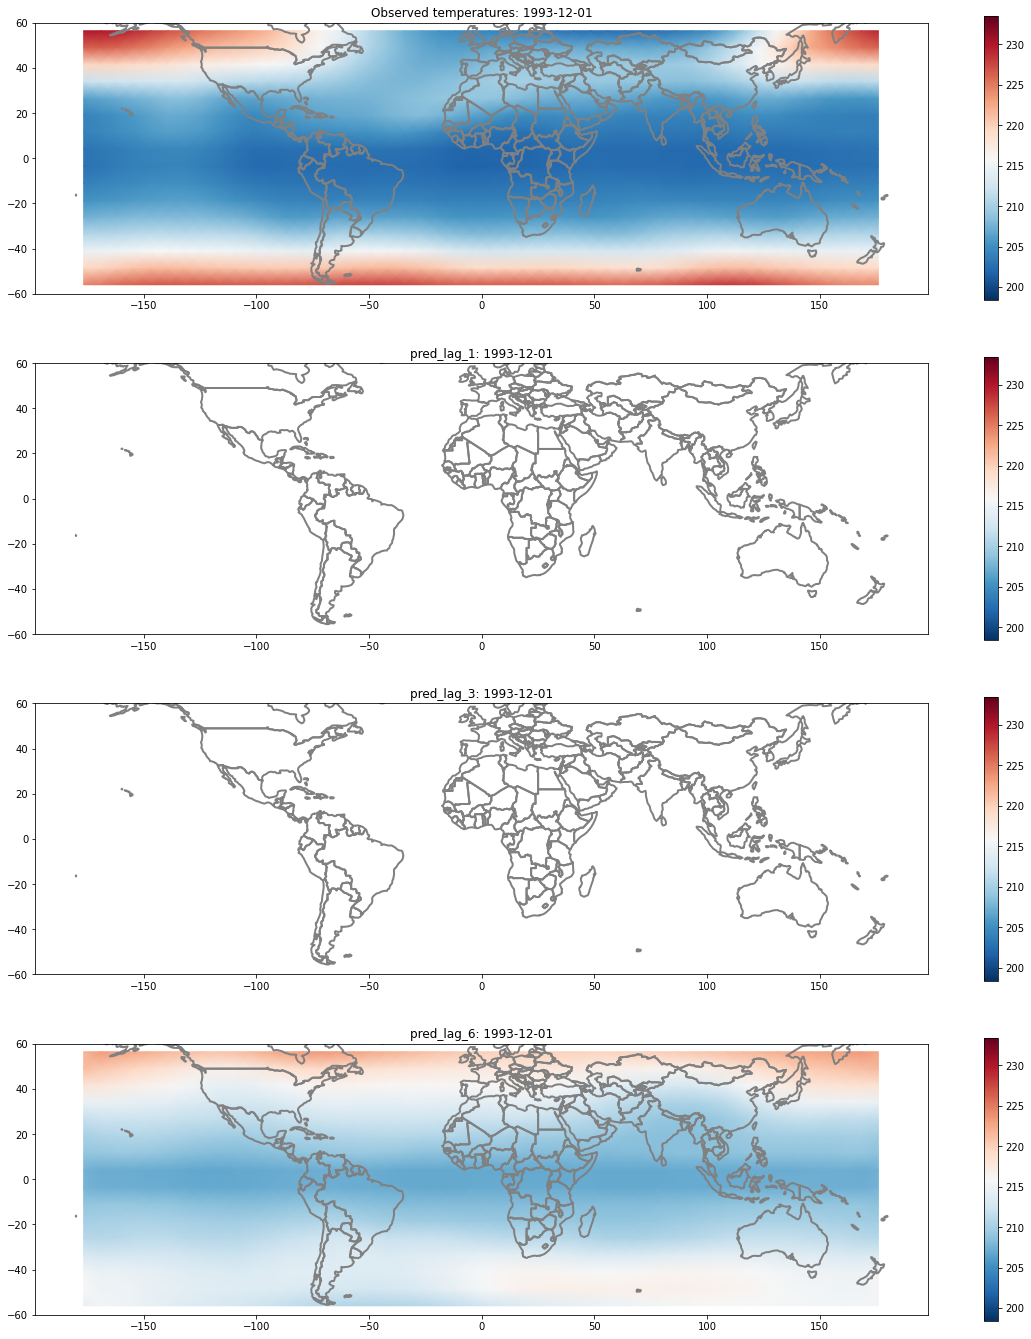

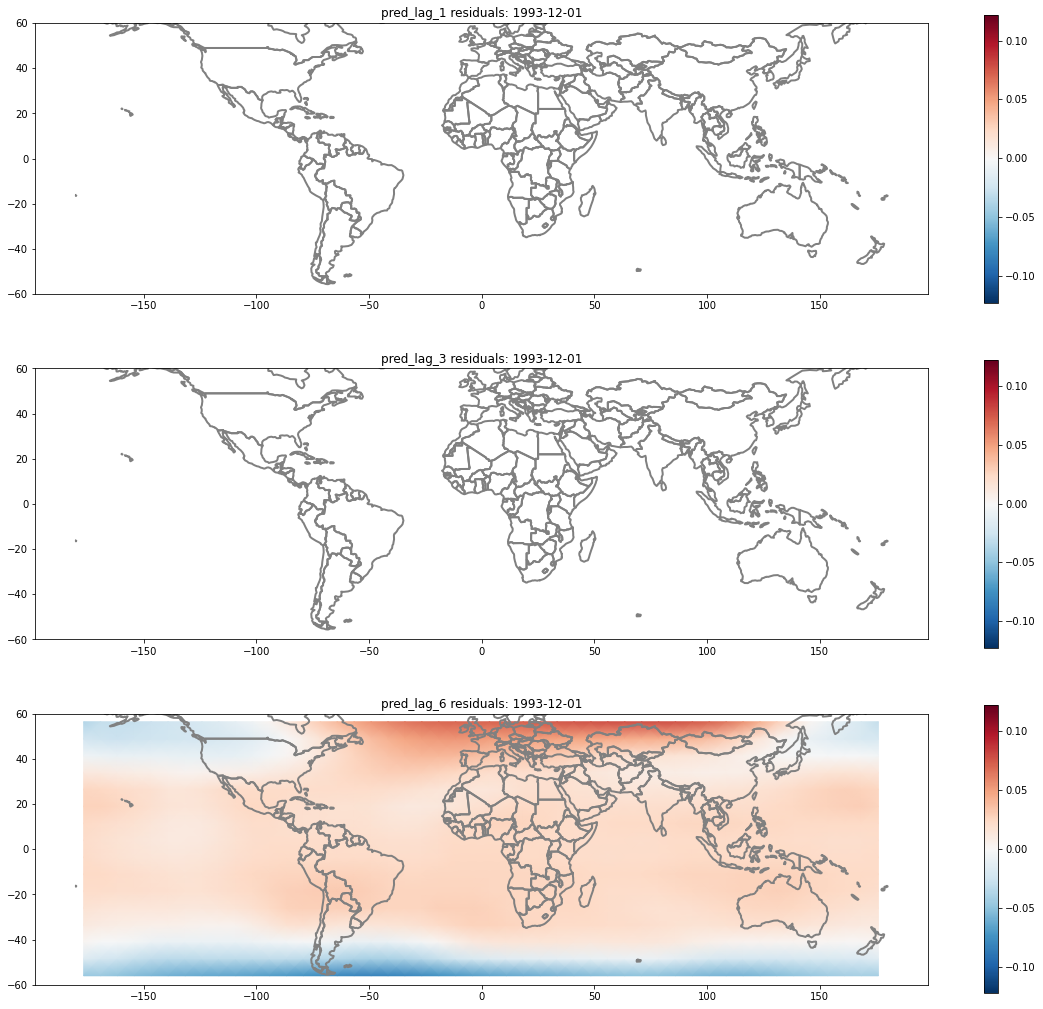

In [44]:
lags = [1,3,6]

animate_predictions(
    true_vals,
    new_pred,
    test_A_labels,
    "images/Test_A_predictions.mov",
    lags=lags
)

animate_residuals(
    true_vals,
    new_pred,
    test_A_labels,
    "images/Test_A_residuals.mov",
    lags=lags
)

In [45]:
class CNN_AOD(nn.Module):
    def __init__(self):
        super().__init__()
        #48 in-channels for context, 6 out-channels for horizon, kernel size 3x3
        self.conv1 = nn.Conv2d(48, 6, 3, padding='same')
        torch.nn.init.uniform_(self.conv1.weight, -1e-6, 1e-6) #Initialize close to 0 randomly
        
    def forward(self, x):
        x = self.conv1(x)
        return x

In [46]:
#Training loop for training set A Temperature and AOD
n_epochs = 10000
learning_rate = 1e-3

cnn_AOD = CNN_AOD()
#criterion = RMSELoss()
optimizer = optim.Adam(cnn_AOD.parameters(), lr = learning_rate)

for i in range(n_epochs):
    avg_loss = 0
    for j in range(len(x_train_A_AOD)):
        cnn_AOD.train()
        outputs = cnn_AOD(x_train_A_AOD[j])
        optimizer.zero_grad()
    
        loss = weighted_RMSE(outputs, y_train_A[j])
        avg_loss += loss
        loss.backward()
    
        optimizer.step()
    avg_loss = avg_loss/len(x_train_A_AOD)
    avg_loss_test = 0
    for k in range(len(x_test_A_AOD)):
        cnn_AOD.eval()
        valid = cnn_AOD(x_test_A_AOD[k])
        test_loss = weighted_RMSE(valid, y_test_A[k])
        avg_loss_test += test_loss
    avg_loss_test = avg_loss_test/len(x_test_A_AOD)
    if i %500 == 0 or i == n_epochs - 1:
        print("Epoch: %d, loss: %1.5f test loss:  %1.5f " %(i, avg_loss , avg_loss_test))

Epoch: 0, loss: 191.20023 test loss:  189.65882 
Epoch: 500, loss: 38.95934 test loss:  41.90667 
Epoch: 1000, loss: 34.92736 test loss:  38.30439 
Epoch: 1500, loss: 31.68735 test loss:  35.10946 
Epoch: 2000, loss: 28.60743 test loss:  31.88379 
Epoch: 2500, loss: 25.58994 test loss:  28.63391 
Epoch: 3000, loss: 22.61244 test loss:  25.38660 
Epoch: 3500, loss: 19.66784 test loss:  22.15966 
Epoch: 4000, loss: 16.75571 test loss:  18.96527 
Epoch: 4500, loss: 13.88084 test loss:  15.81365 
Epoch: 5000, loss: 11.05266 test loss:  12.71424 
Epoch: 5500, loss: 8.29586 test loss:  9.68761 
Epoch: 6000, loss: 5.66752 test loss:  6.78377 
Epoch: 6500, loss: 3.35826 test loss:  4.19304 
Epoch: 7000, loss: 1.99453 test loss:  2.58276 
Epoch: 7500, loss: 1.68837 test loss:  2.11868 
Epoch: 8000, loss: 1.61976 test loss:  1.98253 
Epoch: 8500, loss: 1.59003 test loss:  1.92603 
Epoch: 9000, loss: 1.57294 test loss:  1.89687 
Epoch: 9500, loss: 1.56180 test loss:  1.87945 
Epoch: 9999, loss: 1

In [78]:
PATH = '/Users/joshuapark/Documents/Data_Science/Graduate/SandiaProject/cnn_trainsetA_kernel3x3_temp_AOD'
torch.save(cnn.state_dict(), PATH)

In [47]:
y_pred_A_AOD = []
for i in range(5, 41):
    pred = cnn_AOD(x_test_A_AOD[i])
    y_pred_A_AOD.append(pred)

In [48]:
new_pred_AOD = torch.empty(6,27648)
true_vals_AOD = torch.empty(6,27648)
index = int(0)

for k in range(36):
    for i in range(len(lat_vals)): #Latitudes
        for j in range(len(lon_vals)): #Longitudes
            new_pred_AOD[:,index] = y_pred_A_AOD[k][:,i,j] #Change array shape for animations
            true_vals_AOD[:,index] = y_test_A[k][:,i,j]
            index += 1
new_pred_AOD = new_pred_AOD.detach()
true_vals_AOD = true_vals_AOD.detach()
new_pred_AOD = np.array(new_pred_AOD)
true_vals_AOD = np.array(true_vals_AOD)
new_pred_AOD = np.transpose(new_pred_AOD)
true_vals_AOD = np.transpose(true_vals_AOD)

In [49]:
_ = plot_mean_errors(
    true_vals_AOD,
    new_pred_AOD,
    test_A_labels,
    "Prediction Errors: Training Set A, Temperature and AOD"
    )

In [50]:
lags = [1,3,6]

animate_predictions(
    true_vals_AOD,
    new_pred_AOD,
    test_A_labels,
    "images/Test_A_AOD_predictions.mov",
    lags=lags
)

animate_residuals(
    true_vals_AOD,
    new_pred_AOD,
    test_A_labels,
    "images/Test_A_AOD_residuals.mov",
    lags=lags
)

In [51]:
#Training loop for training set B Temperature only
n_epochs = 8000
learning_rate = 1e-3

cnn_B = CNN()
#criterion = RMSELoss()
optimizer = optim.Adam(cnn_B.parameters(), lr = learning_rate)

for i in range(n_epochs):
    avg_loss = 0
    for j in range(len(x_train_B)):
        cnn_B.train()
        outputs = cnn_B(x_train_B[j])
        optimizer.zero_grad()
    
        loss = weighted_RMSE(outputs, y_train_B[j])
        avg_loss += loss
        loss.backward()
    
        optimizer.step()
    avg_loss = avg_loss/len(x_train_B)
    avg_loss_test = 0
    for k in range(len(x_test_B)):
        cnn_B.eval()
        valid = cnn_B(x_test_B[k])
        test_loss = weighted_RMSE(valid, y_test_B[k])
        avg_loss_test += test_loss
    avg_loss_test = avg_loss_test/len(x_test_B)
    if i %500 == 0 or i == n_epochs-1:
        print("Epoch: %d, loss: %1.5f test loss:  %1.5f " %(i, avg_loss , avg_loss_test))

Epoch: 0, loss: 190.96728 test loss:  189.32797 
Epoch: 500, loss: 43.63643 test loss:  44.00510 
Epoch: 1000, loss: 38.03789 test loss:  39.97610 
Epoch: 1500, loss: 33.04415 test loss:  35.83161 
Epoch: 2000, loss: 28.26694 test loss:  31.40497 
Epoch: 2500, loss: 23.61509 test loss:  26.76698 
Epoch: 3000, loss: 19.07040 test loss:  21.99743 
Epoch: 3500, loss: 14.64374 test loss:  17.16679 
Epoch: 4000, loss: 10.37928 test loss:  12.35684 
Epoch: 4500, loss: 6.40368 test loss:  7.71831 
Epoch: 5000, loss: 3.16704 test loss:  3.72268 
Epoch: 5500, loss: 1.84207 test loss:  1.82835 
Epoch: 6000, loss: 1.68972 test loss:  1.63846 
Epoch: 6500, loss: 1.65367 test loss:  1.63722 
Epoch: 7000, loss: 1.63184 test loss:  1.64317 
Epoch: 7500, loss: 1.61638 test loss:  1.65061 
Epoch: 7999, loss: 1.60508 test loss:  1.65884 


In [79]:
PATH = '/Users/joshuapark/Documents/Data_Science/Graduate/SandiaProject/cnn_trainsetB_kernel3x3_temp'
torch.save(cnn.state_dict(), PATH)

In [52]:
y_pred_B = []
for i in range(5, 30):
    new_pred = cnn_B(x_test_B[i])
    y_pred_B.append(new_pred)

In [53]:
new_pred_B = torch.empty(6,19200)
true_vals_B = torch.empty(6,19200)
index = int(0)

for k in range(25):
    for i in range(len(lat_vals)): #Latitudes
        for j in range(len(lon_vals)): #Longitudes
            new_pred_B[:,index] = y_pred_B[k][:,i,j] #Change array shape for animations
            true_vals_B[:,index] = y_test_B[k][:,i,j]
            index += 1
new_pred_B = new_pred_B.detach()
true_vals_B = true_vals_B.detach()
new_pred_B = np.array(new_pred_B)
true_vals_B = np.array(true_vals_B)
new_pred_B = np.transpose(new_pred_B)
true_vals_B = np.transpose(true_vals_B)

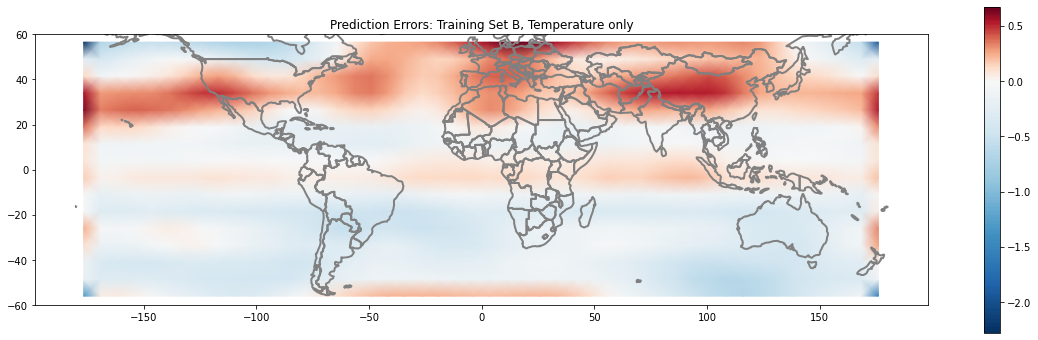

In [54]:
_ = plot_mean_errors(
    true_vals_B,
    new_pred_B,
    test_B_labels,
    "Prediction Errors: Training Set B, Temperature only"
    )

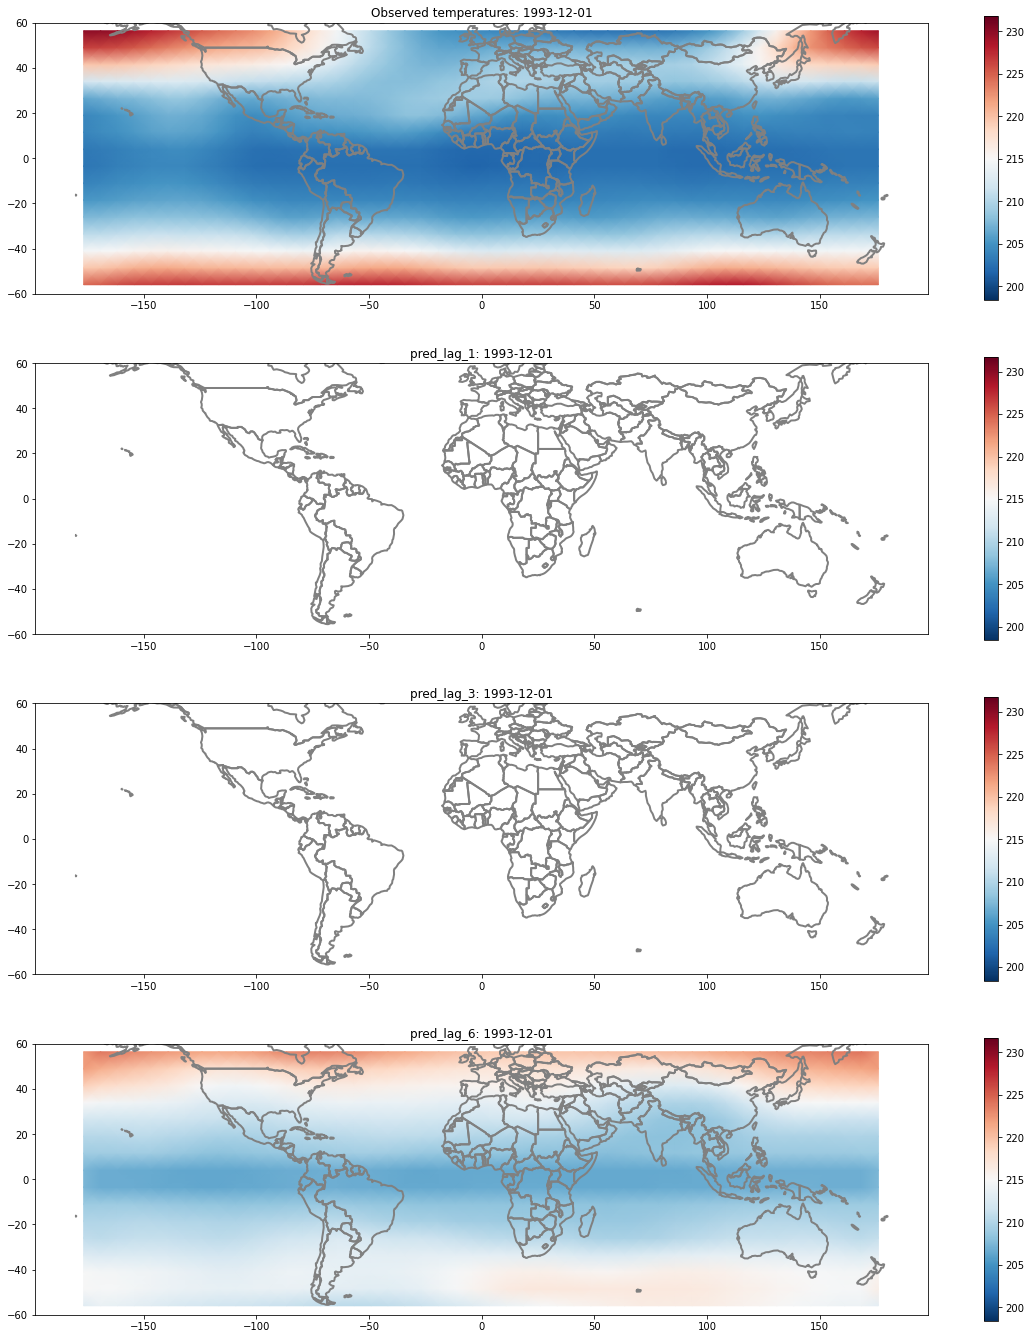

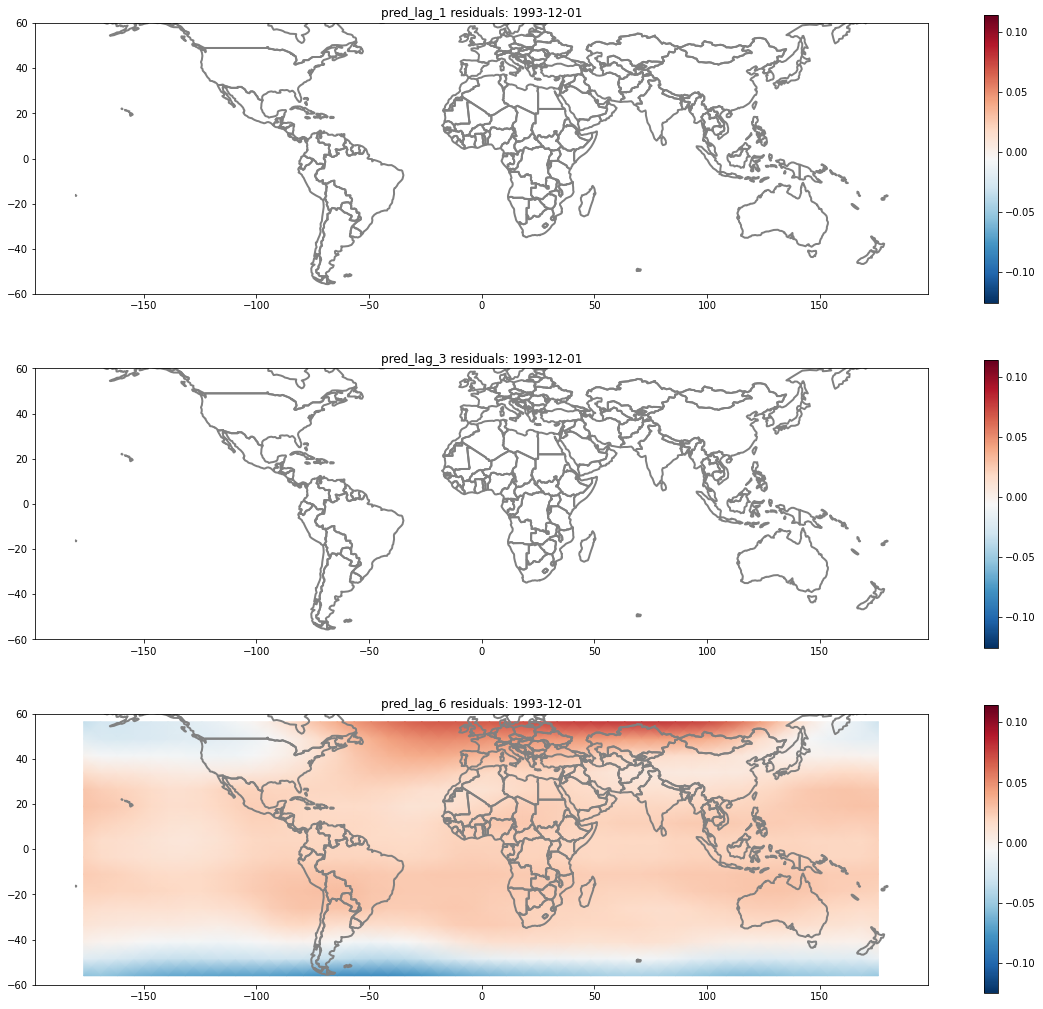

In [55]:
lags = [1,3,6]

animate_predictions(
    true_vals_B,
    new_pred_B,
    test_B_labels,
    "images/Test_B_predictions.mov",
    lags=lags
)

animate_residuals(
    true_vals_B,
    new_pred_B,
    test_B_labels,
    "images/Test_B_residuals.mov",
    lags=lags
)

In [56]:
#Training loop for training set B Temperature and AOD
n_epochs = 8000
learning_rate = 1e-3

cnn_AOD_B = CNN_AOD()
#criterion = RMSELoss()
optimizer = optim.Adam(cnn_AOD_B.parameters(), lr = learning_rate)

for i in range(n_epochs):
    avg_loss = 0
    for j in range(len(x_train_B_AOD)):
        cnn_AOD_B.train()
        outputs = cnn_AOD_B(x_train_B_AOD[j])
        optimizer.zero_grad()
    
        loss = weighted_RMSE(outputs, y_train_B[j])
        avg_loss += loss
        loss.backward()
    
        optimizer.step()
    avg_loss = avg_loss/len(x_train_B_AOD)
    avg_loss_test = 0
    for k in range(len(x_test_B_AOD)):
        cnn_AOD_B.eval()
        valid = cnn_AOD_B(x_test_B_AOD[k])
        test_loss = weighted_RMSE(valid, y_test_B[k])
        avg_loss_test += test_loss
    avg_loss_test = avg_loss_test/len(x_test_B_AOD)
    if i %500 == 0 or i == n_epochs-1:
        print("Epoch: %d, loss: %1.5f test loss:  %1.5f " %(i, avg_loss , avg_loss_test))

Epoch: 0, loss: 190.75527 test loss:  188.62505 
Epoch: 500, loss: 37.01341 test loss:  40.41243 
Epoch: 1000, loss: 32.41447 test loss:  36.28435 
Epoch: 1500, loss: 28.34984 test loss:  32.21170 
Epoch: 2000, loss: 24.41613 test loss:  28.02157 
Epoch: 2500, loss: 20.56631 test loss:  23.77737 
Epoch: 3000, loss: 16.79688 test loss:  19.53144 
Epoch: 3500, loss: 13.12275 test loss:  15.33143 
Epoch: 4000, loss: 9.58342 test loss:  11.23942 
Epoch: 4500, loss: 6.28076 test loss:  7.37926 
Epoch: 5000, loss: 3.51830 test loss:  4.09655 
Epoch: 5500, loss: 2.03794 test loss:  2.27842 
Epoch: 6000, loss: 1.71248 test loss:  1.91520 
Epoch: 6500, loss: 1.64721 test loss:  1.86649 
Epoch: 7000, loss: 1.62175 test loss:  1.84508 
Epoch: 7500, loss: 1.60670 test loss:  1.83035 
Epoch: 7999, loss: 1.59639 test loss:  1.82066 


In [80]:
PATH = '/Users/joshuapark/Documents/Data_Science/Graduate/SandiaProject/cnn_trainsetB_kernel3x3_temp_AOD'
torch.save(cnn.state_dict(), PATH)

In [57]:
y_pred_B_AOD = []
for i in range(5, 30):
    pred = cnn_AOD_B(x_test_B_AOD[i])
    y_pred_B_AOD.append(pred)

In [58]:
new_pred_AOD_B = torch.empty(6,19200)
true_vals_AOD_B = torch.empty(6,19200)
index = int(0)

for k in range(25):
    for i in range(len(lat_vals)): #Latitudes
        for j in range(len(lon_vals)): #Longitudes
            new_pred_AOD_B[:,index] = y_pred_B_AOD[k][:,i,j] #Change array shape for animations
            true_vals_AOD_B[:,index] = y_test_B[k][:,i,j]
            index += 1
new_pred_AOD_B = new_pred_AOD_B.detach()
true_vals_AOD_B = true_vals_AOD_B.detach()
new_pred_AOD_B = np.array(new_pred_AOD_B)
true_vals_AOD_B = np.array(true_vals_AOD_B)
new_pred_AOD_B = np.transpose(new_pred_AOD_B)
true_vals_AOD_B = np.transpose(true_vals_AOD_B)

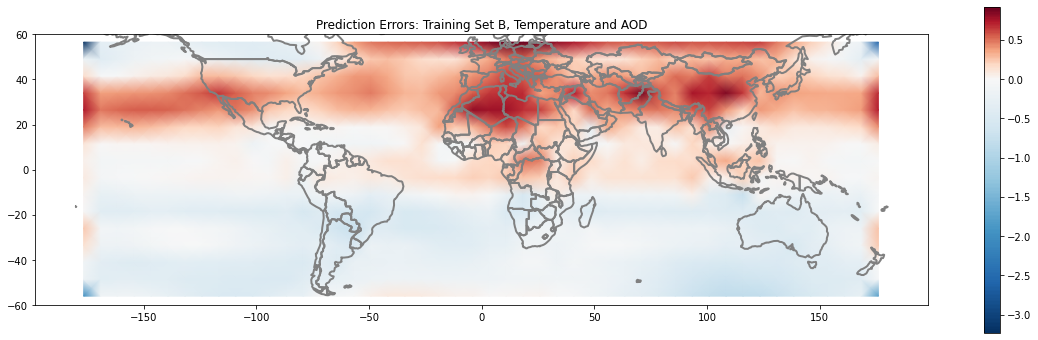

In [59]:
_ = plot_mean_errors(
    true_vals_AOD_B,
    new_pred_AOD_B,
    test_B_labels,
    "Prediction Errors: Training Set B, Temperature and AOD"
    )

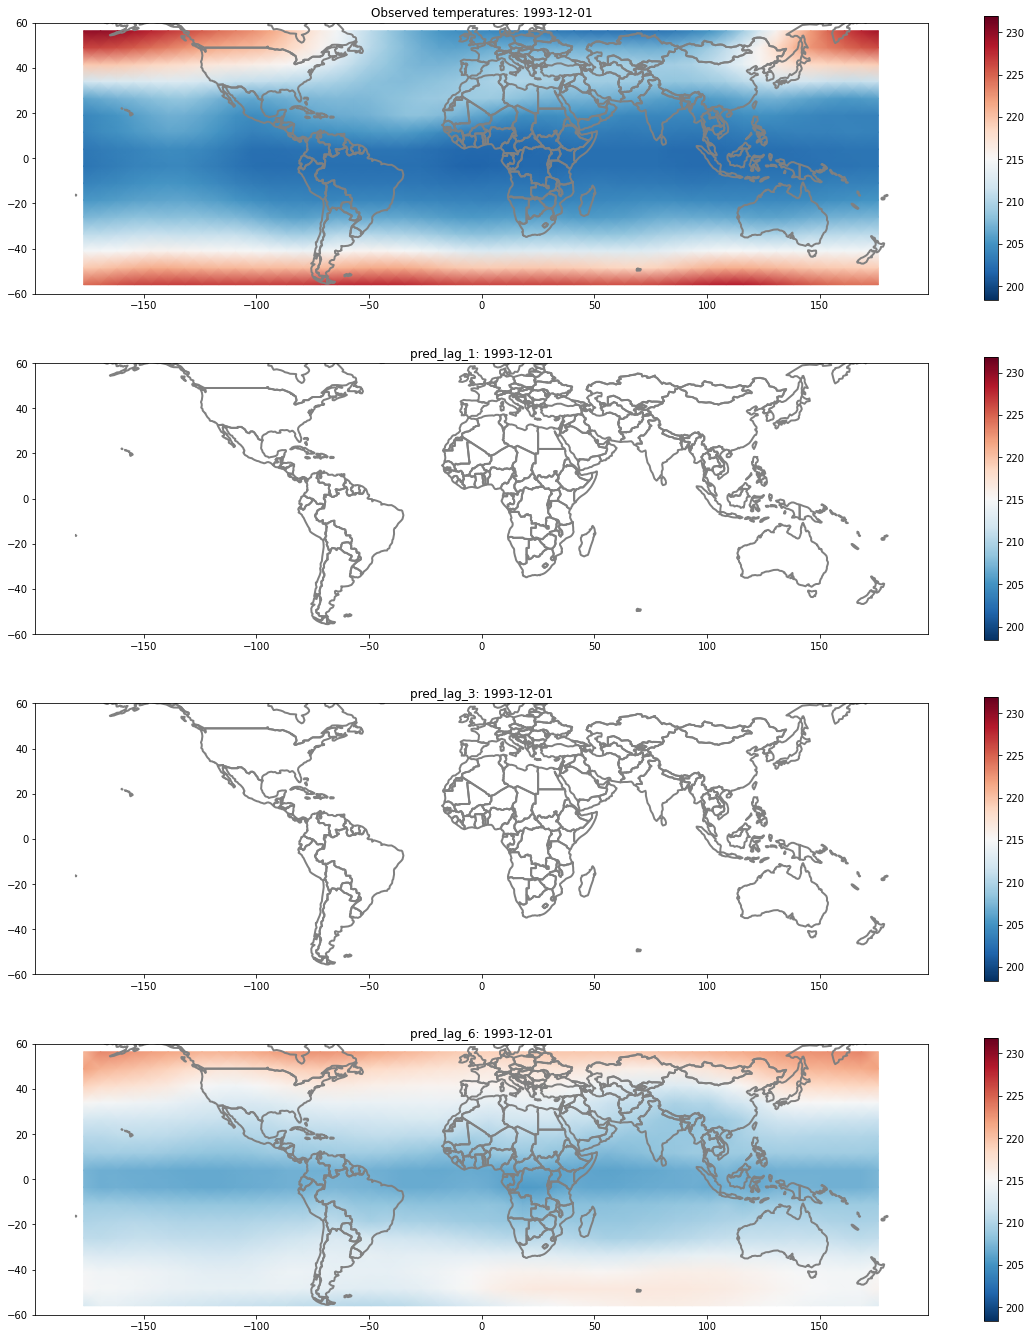

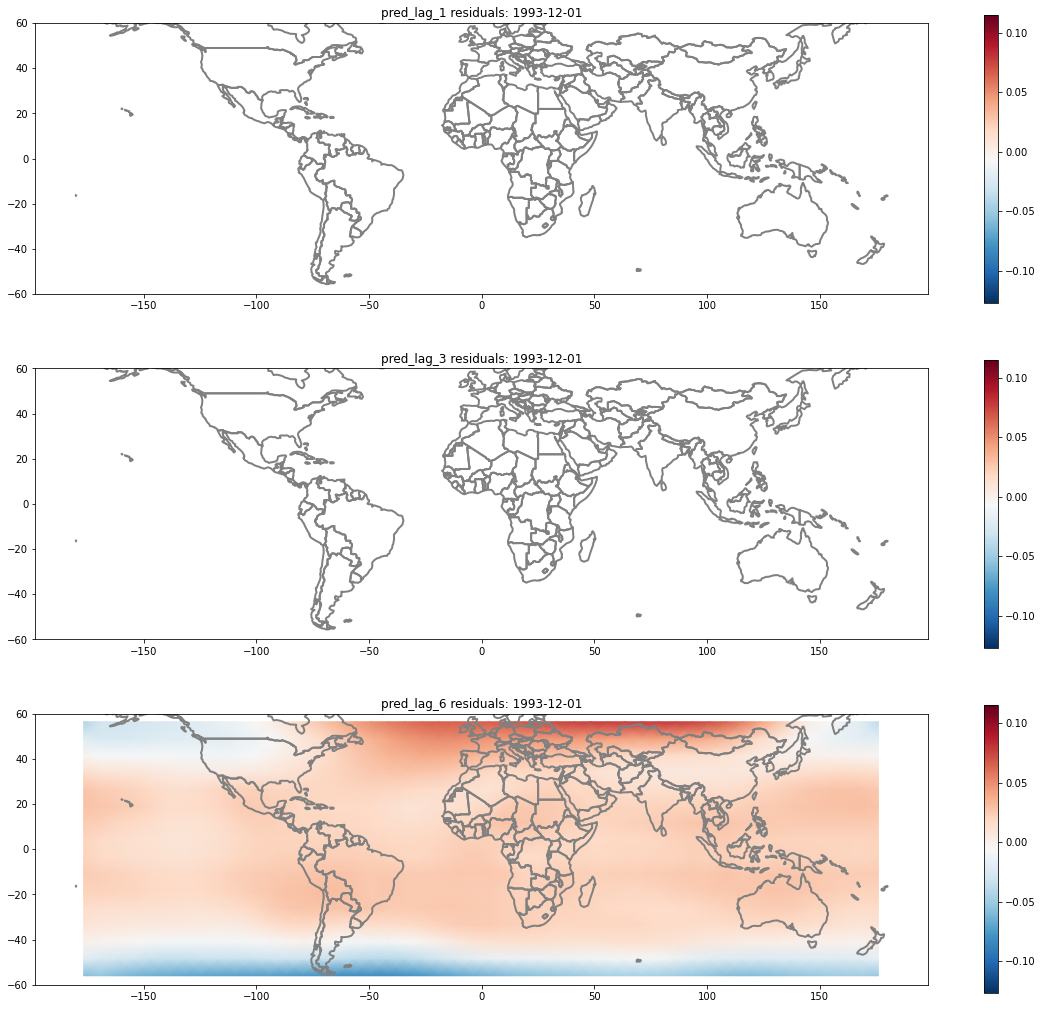

In [60]:
lags = [1,3,6]

animate_predictions(
    true_vals_AOD_B,
    new_pred_AOD_B,
    test_B_labels,
    "images/Test_B_AOD_predictions.mov",
    lags=lags
)

animate_residuals(
    true_vals_AOD_B,
    new_pred_AOD_B,
    test_B_labels,
    "images/Test_B_AOD_residuals.mov",
    lags=lags
)

In [61]:
for param in cnn_AOD.parameters():
    print(param)

Parameter containing:
tensor([[[[-2.2798e-01, -4.3666e-03, -1.1376e-01],
          [ 1.9635e+00,  3.2305e+00,  2.3687e+00],
          [-7.4451e-01,  3.2514e-01, -1.7014e-01]],

         [[ 6.6216e-01,  5.9706e-01,  2.8293e-01],
          [ 2.4181e+00,  3.3687e+00,  2.2170e+00],
          [-4.3729e-01,  3.5236e-01, -4.5210e-01]],

         [[-1.4423e+00, -6.0053e-01, -3.1894e-01],
          [-2.2393e-02,  1.4360e+00,  9.5889e-01],
          [-5.6918e-01,  5.1323e-01, -1.3146e-01]],

         ...,

         [[ 2.5349e-01, -9.9254e-02,  3.7186e-01],
          [ 1.2734e-01,  2.2168e-01, -4.8928e-01],
          [ 6.4678e-01,  5.0142e-01,  5.2673e-01]],

         [[-7.5536e-02, -4.0883e-02, -1.3184e-01],
          [-5.7798e-01,  1.1465e+00,  7.3767e-01],
          [-1.2197e+00,  1.2475e-01,  6.3289e-01]],

         [[ 8.5145e-01,  3.1938e-01,  2.6628e-01],
          [-1.3017e+00,  5.3408e-01, -2.6120e-01],
          [-1.3627e+00, -1.2366e-01, -5.4584e-01]]],


        [[[-1.4862e-01, -2.3507

In [62]:
class CNN_5(nn.Module):
    def __init__(self):
        super().__init__()
        #24 in-channels for context, 6 out-channels for horizon, kernel size 3x5
        self.conv1 = nn.Conv2d(24, 6, (3, 5), padding='same') 
        #self.conv2 = nn.Conv2d(24, 6, 3, padding='same')
    
    def forward(self, x):
        x = self.conv1(x)
        return x

In [63]:
class CNN_7(nn.Module):
    def __init__(self):
        super().__init__()
        #24 in-channels for context, 6 out-channels for horizon, kernel size 3x7
        self.conv1 = nn.Conv2d(24, 6, (3, 7), padding='same') 
        #self.conv2 = nn.Conv2d(24, 6, 3, padding='same')
    
    def forward(self, x):
        x = self.conv1(x)
        return x

In [64]:
class CNN_AOD_5(nn.Module):
    def __init__(self):
        super().__init__()
        #48 in-channels for context, 6 out-channels for horizon, kernel size 3x5
        self.conv1 = nn.Conv2d(48, 6, (3, 5), padding='same')
        torch.nn.init.uniform_(self.conv1.weight, -1e-6, 1e-6) #Initialize close to 0 randomly
        
    def forward(self, x):
        x = self.conv1(x)
        return x

In [65]:
class CNN_AOD_7(nn.Module):
    def __init__(self):
        super().__init__()
        #48 in-channels for context, 6 out-channels for horizon, kernel size 7x7
        self.conv1 = nn.Conv2d(48, 6, 7, padding='same')
        torch.nn.init.uniform_(self.conv1.weight, -1e-6, 1e-6) #Initialize close to 0 randomly
        
    def forward(self, x):
        x = self.conv1(x)
        return x

In [81]:
#Training loop for training set A Temperature only, kernel size 3x5
n_epochs = 10000
learning_rate = 1e-3

cnn_5 = CNN_5()
#criterion = weighted_RMSE()
optimizer = optim.Adam(cnn_5.parameters(), lr = learning_rate)

for i in range(n_epochs):
    avg_loss = 0
    for j in range(len(x_train_A)):
        cnn_5.train()
        outputs = cnn_5(x_train_A[j])
        optimizer.zero_grad()
    
        loss = weighted_RMSE(outputs, y_train_A[j])
        avg_loss += loss
        loss.backward()
    
        optimizer.step()
    avg_loss = avg_loss/len(x_train_A)
    avg_loss_test = 0
    for k in range(len(x_test_A)):
        cnn_5.eval()
        valid = cnn_5(x_test_A[k])
        test_loss = weighted_RMSE(valid, y_test_A[k])
        avg_loss_test += test_loss
    avg_loss_test = avg_loss_test/len(x_test_A)
    if i %500 == 0 or i == n_epochs - 1:
        print("Epoch: %d, loss: %1.5f test loss:  %1.5f " %(i, avg_loss , avg_loss_test))

Epoch: 0, loss: 190.78242 test loss:  188.85685 
Epoch: 500, loss: 45.97924 test loss:  44.90512 
Epoch: 1000, loss: 41.41692 test loss:  41.82187 
Epoch: 1500, loss: 37.56002 test loss:  38.75480 
Epoch: 2000, loss: 33.90471 test loss:  35.48514 
Epoch: 2500, loss: 30.33114 test loss:  32.06029 
Epoch: 3000, loss: 26.80212 test loss:  28.53408 
Epoch: 3500, loss: 23.30562 test loss:  24.94646 
Epoch: 4000, loss: 19.83995 test loss:  21.32669 
Epoch: 4500, loss: 16.40847 test loss:  17.69692 
Epoch: 5000, loss: 13.02372 test loss:  14.08032 
Epoch: 5500, loss: 9.71228 test loss:  10.50805 
Epoch: 6000, loss: 6.53589 test loss:  7.04021 
Epoch: 6500, loss: 3.70951 test loss:  3.88680 
Epoch: 7000, loss: 2.04185 test loss:  1.98149 
Epoch: 7500, loss: 1.72113 test loss:  1.73329 
Epoch: 8000, loss: 1.64544 test loss:  1.72783 
Epoch: 8500, loss: 1.60692 test loss:  1.73374 
Epoch: 9000, loss: 1.58400 test loss:  1.74298 
Epoch: 9500, loss: 1.56979 test loss:  1.75331 
Epoch: 9999, loss: 

In [85]:
PATH = '/Users/joshuapark/Documents/Data_Science/Graduate/SandiaProject/cnn_trainsetA_kernel3x5_temp'
torch.save(cnn.state_dict(), PATH)

In [82]:
#Training loop for training set A Temperature only, kernel size 3x7
n_epochs = 10000
learning_rate = 1e-3

cnn_7 = CNN_7()
#criterion = weighted_RMSE()
optimizer = optim.Adam(cnn_7.parameters(), lr = learning_rate)

for i in range(n_epochs):
    avg_loss = 0
    for j in range(len(x_train_A)):
        cnn_7.train()
        outputs = cnn_7(x_train_A[j])
        optimizer.zero_grad()
    
        loss = weighted_RMSE(outputs, y_train_A[j])
        avg_loss += loss
        loss.backward()
    
        optimizer.step()
    avg_loss = avg_loss/len(x_train_A)
    avg_loss_test = 0
    for k in range(len(x_test_A)):
        cnn_7.eval()
        valid = cnn_7(x_test_A[k])
        test_loss = weighted_RMSE(valid, y_test_A[k])
        avg_loss_test += test_loss
    avg_loss_test = avg_loss_test/len(x_test_A)
    if i %500 == 0 or i == n_epochs-1:
        print("Epoch: %d, loss: %1.5f test loss:  %1.5f " %(i, avg_loss , avg_loss_test))

Epoch: 0, loss: 190.11225 test loss:  187.48180 
Epoch: 500, loss: 45.67868 test loss:  45.05120 
Epoch: 1000, loss: 41.23977 test loss:  42.11539 
Epoch: 1500, loss: 37.46469 test loss:  38.99696 
Epoch: 2000, loss: 33.85932 test loss:  35.64723 
Epoch: 2500, loss: 30.31799 test loss:  32.15611 
Epoch: 3000, loss: 26.81232 test loss:  28.58738 
Epoch: 3500, loss: 23.33587 test loss:  24.98132 
Epoch: 4000, loss: 19.89012 test loss:  21.36381 
Epoch: 4500, loss: 16.48118 test loss:  17.75323 
Epoch: 5000, loss: 13.12395 test loss:  14.16949 
Epoch: 5500, loss: 9.84495 test loss:  10.63906 
Epoch: 6000, loss: 6.71128 test loss:  7.22414 
Epoch: 6500, loss: 3.92658 test loss:  4.12174 
Epoch: 7000, loss: 2.17757 test loss:  2.11664 
Epoch: 7500, loss: 1.75346 test loss:  1.74881 
Epoch: 8000, loss: 1.65260 test loss:  1.73460 
Epoch: 8500, loss: 1.60437 test loss:  1.74248 
Epoch: 9000, loss: 1.57804 test loss:  1.75603 
Epoch: 9500, loss: 1.56344 test loss:  1.77036 
Epoch: 9999, loss: 

In [83]:
PATH = '/Users/joshuapark/Documents/Data_Science/Graduate/SandiaProject/cnn_trainsetA_kernel3x7_temp'
torch.save(cnn.state_dict(), PATH)

In [84]:
class CNN_flux(nn.Module):
    def __init__(self):
        super().__init__()
        #48 in-channels for context, 6 out-channels for horizon, kernel size 3x3
        self.conv1 = nn.Conv2d(48, 6, 3, padding='same')
        
    def forward(self, x):
        x = self.conv1(x)
        return x

In [87]:
#Training loop for training set A Temperature and SW random weights
n_epochs = 12000
learning_rate = 1e-3

cnn_SW = CNN_flux()
#criterion = RMSELoss()
optimizer = optim.Adam(cnn_SW.parameters(), lr = learning_rate)

for i in range(n_epochs):
    avg_loss = 0
    for j in range(len(x_train_A_SW)):
        cnn_SW.train()
        outputs = cnn_SW(x_train_A_SW[j])
        optimizer.zero_grad()
    
        loss = weighted_RMSE(outputs, y_train_A[j])
        avg_loss += loss
        loss.backward()
    
        optimizer.step()
    avg_loss = avg_loss/len(x_train_A_SW)
    avg_loss_test = 0
    for k in range(len(x_test_A_SW)):
        cnn_SW.eval()
        valid = cnn_SW(x_test_A_SW[k])
        test_loss = weighted_RMSE(valid, y_test_A[k])
        avg_loss_test += test_loss
    avg_loss_test = avg_loss_test/len(x_test_A_SW)
    if i %500 == 0 or i == n_epochs - 1:
        print("Epoch: %d, loss: %1.5f test loss:  %1.5f " %(i, avg_loss , avg_loss_test))

Epoch: 0, loss: 189.64318 test loss:  186.72958 
Epoch: 500, loss: 8.93452 test loss:  9.27846 
Epoch: 1000, loss: 8.40943 test loss:  8.80067 
Epoch: 1500, loss: 8.02612 test loss:  8.44684 
Epoch: 2000, loss: 7.69762 test loss:  8.13322 
Epoch: 2500, loss: 7.39186 test loss:  7.83214 
Epoch: 3000, loss: 7.09716 test loss:  7.53563 
Epoch: 3500, loss: 6.80951 test loss:  7.24212 
Epoch: 4000, loss: 6.52776 test loss:  6.95197 
Epoch: 4500, loss: 6.25172 test loss:  6.66592 
Epoch: 5000, loss: 5.98145 test loss:  6.38463 
Epoch: 5500, loss: 5.71729 test loss:  6.10883 
Epoch: 6000, loss: 5.45952 test loss:  5.83908 
Epoch: 6500, loss: 5.20854 test loss:  5.57599 
Epoch: 7000, loss: 4.96467 test loss:  5.32006 
Epoch: 7500, loss: 4.72823 test loss:  5.07174 
Epoch: 8000, loss: 4.49971 test loss:  4.83162 
Epoch: 8500, loss: 4.27935 test loss:  4.60010 
Epoch: 9000, loss: 4.06768 test loss:  4.37775 
Epoch: 9500, loss: 3.86496 test loss:  4.16495 
Epoch: 10000, loss: 3.67157 test loss:  

In [71]:
#Training loop for training set A Temperature and SW weights close to 0
n_epochs = 12000
learning_rate = 1e-3

cnn_SW = CNN_AOD()
#criterion = RMSELoss()
optimizer = optim.Adam(cnn_SW.parameters(), lr = learning_rate)

for i in range(n_epochs):
    avg_loss = 0
    for j in range(len(x_train_A_SW)):
        cnn_SW.train()
        outputs = cnn_SW(x_train_A_SW[j])
        optimizer.zero_grad()
    
        loss = weighted_RMSE(outputs, y_train_A[j])
        avg_loss += loss
        loss.backward()
    
        optimizer.step()
    avg_loss = avg_loss/len(x_train_A_SW)
    avg_loss_test = 0
    for k in range(len(x_test_A_SW)):
        cnn_SW.eval()
        valid = cnn_SW(x_test_A_SW[k])
        test_loss = weighted_RMSE(valid, y_test_A[k])
        avg_loss_test += test_loss
    avg_loss_test = avg_loss_test/len(x_test_A_SW)
    if i %500 == 0 or i == n_epochs - 1:
        print("Epoch: %d, loss: %1.5f test loss:  %1.5f " %(i, avg_loss , avg_loss_test))

Epoch: 0, loss: 189.71619 test loss:  186.80443 
Epoch: 500, loss: 8.93374 test loss:  9.27767 
Epoch: 1000, loss: 8.40845 test loss:  8.79962 
Epoch: 1500, loss: 8.02509 test loss:  8.44573 
Epoch: 2000, loss: 7.69657 test loss:  8.13211 
Epoch: 2500, loss: 7.39083 test loss:  7.83104 
Epoch: 3000, loss: 7.09614 test loss:  7.53454 
Epoch: 3500, loss: 6.80852 test loss:  7.24106 
Epoch: 4000, loss: 6.52679 test loss:  6.95094 
Epoch: 4500, loss: 6.25076 test loss:  6.66490 
Epoch: 5000, loss: 5.98052 test loss:  6.38363 
Epoch: 5500, loss: 5.71639 test loss:  6.10786 
Epoch: 6000, loss: 5.45864 test loss:  5.83813 
Epoch: 6500, loss: 5.20768 test loss:  5.57508 
Epoch: 7000, loss: 4.96385 test loss:  5.31918 
Epoch: 7500, loss: 4.72744 test loss:  5.07090 
Epoch: 8000, loss: 4.49896 test loss:  4.83083 
Epoch: 8500, loss: 4.27864 test loss:  4.59934 
Epoch: 9000, loss: 4.06700 test loss:  4.37702 
Epoch: 9500, loss: 3.86432 test loss:  4.16427 
Epoch: 10000, loss: 3.67097 test loss:  

In [88]:
#Training loop for training set A Temperature and LW random weights
n_epochs = 12000
learning_rate = 1e-3

cnn_LW = CNN_flux()
#criterion = RMSELoss()
optimizer = optim.Adam(cnn_LW.parameters(), lr = learning_rate)

for i in range(n_epochs):
    avg_loss = 0
    for j in range(len(x_train_A_LW)):
        cnn_LW.train()
        outputs = cnn_LW(x_train_A_LW[j])
        optimizer.zero_grad()
    
        loss = weighted_RMSE(outputs, y_train_A[j])
        avg_loss += loss
        loss.backward()
    
        optimizer.step()
    avg_loss = avg_loss/len(x_train_A_LW)
    avg_loss_test = 0
    for k in range(len(x_test_A_LW)):
        cnn_LW.eval()
        valid = cnn_LW(x_test_A_LW[k])
        test_loss = weighted_RMSE(valid, y_test_A[k])
        avg_loss_test += test_loss
    avg_loss_test = avg_loss_test/len(x_test_A_LW)
    if i %500 == 0 or i == n_epochs - 1:
        print("Epoch: %d, loss: %1.5f test loss:  %1.5f " %(i, avg_loss , avg_loss_test))

Epoch: 0, loss: 189.97233 test loss:  187.32160 
Epoch: 500, loss: 17.58085 test loss:  17.47099 
Epoch: 1000, loss: 15.67111 test loss:  15.74899 
Epoch: 1500, loss: 14.48503 test loss:  14.62064 
Epoch: 2000, loss: 13.36342 test loss:  13.52207 
Epoch: 2500, loss: 12.26483 test loss:  12.43099 
Epoch: 3000, loss: 11.18737 test loss:  11.35282 
Epoch: 3500, loss: 10.13195 test loss:  10.29197 
Epoch: 4000, loss: 9.10087 test loss:  9.25275 
Epoch: 4500, loss: 8.09802 test loss:  8.24043 
Epoch: 5000, loss: 7.12885 test loss:  7.26152 
Epoch: 5500, loss: 6.20093 test loss:  6.32464 
Epoch: 6000, loss: 5.32419 test loss:  5.44090 
Epoch: 6500, loss: 4.51210 test loss:  4.62525 
Epoch: 7000, loss: 3.78150 test loss:  3.89639 
Epoch: 7500, loss: 3.15177 test loss:  3.27573 
Epoch: 8000, loss: 2.64090 test loss:  2.78245 
Epoch: 8500, loss: 2.25712 test loss:  2.42366 
Epoch: 9000, loss: 1.99130 test loss:  2.18645 
Epoch: 9500, loss: 1.81971 test loss:  2.04258 
Epoch: 10000, loss: 1.7142

In [73]:
#Training loop for training set A Temperature and LW weights close to 0
n_epochs = 12000
learning_rate = 1e-3

cnn_LW = CNN_AOD()
#criterion = RMSELoss()
optimizer = optim.Adam(cnn_LW.parameters(), lr = learning_rate)

for i in range(n_epochs):
    avg_loss = 0
    for j in range(len(x_train_A_LW)):
        cnn_LW.train()
        outputs = cnn_LW(x_train_A_LW[j])
        optimizer.zero_grad()
    
        loss = weighted_RMSE(outputs, y_train_A[j])
        avg_loss += loss
        loss.backward()
    
        optimizer.step()
    avg_loss = avg_loss/len(x_train_A_LW)
    avg_loss_test = 0
    for k in range(len(x_test_A_LW)):
        cnn_LW.eval()
        valid = cnn_LW(x_test_A_LW[k])
        test_loss = weighted_RMSE(valid, y_test_A[k])
        avg_loss_test += test_loss
    avg_loss_test = avg_loss_test/len(x_test_A_LW)
    if i %500 == 0 or i == n_epochs - 1:
        print("Epoch: %d, loss: %1.5f test loss:  %1.5f " %(i, avg_loss , avg_loss_test))

Epoch: 0, loss: 190.01093 test loss:  187.36354 
Epoch: 500, loss: 17.58218 test loss:  17.47208 
Epoch: 1000, loss: 15.67276 test loss:  15.75052 
Epoch: 1500, loss: 14.48666 test loss:  14.62223 
Epoch: 2000, loss: 13.36500 test loss:  13.52364 
Epoch: 2500, loss: 12.26638 test loss:  12.43253 
Epoch: 3000, loss: 11.18890 test loss:  11.35435 
Epoch: 3500, loss: 10.13344 test loss:  10.29346 
Epoch: 4000, loss: 9.10231 test loss:  9.25419 
Epoch: 4500, loss: 8.09942 test loss:  8.24182 
Epoch: 5000, loss: 7.13020 test loss:  7.26286 
Epoch: 5500, loss: 6.20221 test loss:  6.32590 
Epoch: 6000, loss: 5.32538 test loss:  5.44207 
Epoch: 6500, loss: 4.51319 test loss:  4.62631 
Epoch: 7000, loss: 3.78245 test loss:  3.89732 
Epoch: 7500, loss: 3.15258 test loss:  3.27650 
Epoch: 8000, loss: 2.64154 test loss:  2.78303 
Epoch: 8500, loss: 2.25757 test loss:  2.42405 
Epoch: 9000, loss: 1.99159 test loss:  2.18669 
Epoch: 9500, loss: 1.81988 test loss:  2.04271 
Epoch: 10000, loss: 1.7143

In [89]:
#Training loop for training set A Temperature and net flux (SW-LW) weights close to 0
n_epochs = 12000
learning_rate = 1e-3

cnn_flux = CNN_flux()
#criterion = RMSELoss()
optimizer = optim.Adam(cnn_flux.parameters(), lr = learning_rate)

for i in range(n_epochs):
    avg_loss = 0
    for j in range(len(x_train_A_flux)):
        cnn_flux.train()
        outputs = cnn_flux(x_train_A_flux[j])
        optimizer.zero_grad()
    
        loss = weighted_RMSE(outputs, y_train_A[j])
        avg_loss += loss
        loss.backward()
    
        optimizer.step()
    avg_loss = avg_loss/len(x_train_A_flux)
    avg_loss_test = 0
    for k in range(len(x_test_A_flux)):
        cnn_flux.eval()
        valid = cnn_flux(x_test_A_flux[k])
        test_loss = weighted_RMSE(valid, y_test_A[k])
        avg_loss_test += test_loss
    avg_loss_test = avg_loss_test/len(x_test_A_flux)
    if i %500 == 0 or i == n_epochs - 1:
        print("Epoch: %d, loss: %1.5f test loss:  %1.5f " %(i, avg_loss , avg_loss_test))

Epoch: 0, loss: 189.78761 test loss:  186.87219 
Epoch: 500, loss: 8.47573 test loss:  8.69727 
Epoch: 1000, loss: 8.06870 test loss:  8.34058 
Epoch: 1500, loss: 7.73335 test loss:  8.04059 
Epoch: 2000, loss: 7.43096 test loss:  7.76023 
Epoch: 2500, loss: 7.14545 test loss:  7.48691 
Epoch: 3000, loss: 6.86951 test loss:  7.21633 
Epoch: 3500, loss: 6.59993 test loss:  6.94751 
Epoch: 4000, loss: 6.33539 test loss:  6.68060 
Epoch: 4500, loss: 6.07554 test loss:  6.41630 
Epoch: 5000, loss: 5.82042 test loss:  6.15537 
Epoch: 5500, loss: 5.57039 test loss:  5.89865 
Epoch: 6000, loss: 5.32588 test loss:  5.64693 
Epoch: 6500, loss: 5.08727 test loss:  5.40085 
Epoch: 7000, loss: 4.85495 test loss:  5.16098 
Epoch: 7500, loss: 4.62958 test loss:  4.92814 
Epoch: 8000, loss: 4.41151 test loss:  4.70277 
Epoch: 8500, loss: 4.20131 test loss:  4.48555 
Epoch: 9000, loss: 3.99943 test loss:  4.27701 
Epoch: 9500, loss: 3.80622 test loss:  4.07758 
Epoch: 10000, loss: 3.62226 test loss:  

In [72]:
#Training loop for training set A Temperature and net flux (SW-LW) weights close to 0
n_epochs = 12000
learning_rate = 1e-3

cnn_flux = CNN_AOD()
#criterion = RMSELoss()
optimizer = optim.Adam(cnn_flux.parameters(), lr = learning_rate)

for i in range(n_epochs):
    avg_loss = 0
    for j in range(len(x_train_A_flux)):
        cnn_flux.train()
        outputs = cnn_flux(x_train_A_flux[j])
        optimizer.zero_grad()
    
        loss = weighted_RMSE(outputs, y_train_A[j])
        avg_loss += loss
        loss.backward()
    
        optimizer.step()
    avg_loss = avg_loss/len(x_train_A_flux)
    avg_loss_test = 0
    for k in range(len(x_test_A_flux)):
        cnn_flux.eval()
        valid = cnn_flux(x_test_A_flux[k])
        test_loss = weighted_RMSE(valid, y_test_A[k])
        avg_loss_test += test_loss
    avg_loss_test = avg_loss_test/len(x_test_A_flux)
    if i %500 == 0 or i == n_epochs - 1:
        print("Epoch: %d, loss: %1.5f test loss:  %1.5f " %(i, avg_loss , avg_loss_test))

Epoch: 0, loss: 189.72392 test loss:  186.80996 
Epoch: 500, loss: 8.47523 test loss:  8.69634 
Epoch: 1000, loss: 8.06821 test loss:  8.33984 
Epoch: 1500, loss: 7.73288 test loss:  8.03992 
Epoch: 2000, loss: 7.43051 test loss:  7.75962 
Epoch: 2500, loss: 7.14504 test loss:  7.48635 
Epoch: 3000, loss: 6.86913 test loss:  7.21583 
Epoch: 3500, loss: 6.59960 test loss:  6.94706 
Epoch: 4000, loss: 6.33508 test loss:  6.68018 
Epoch: 4500, loss: 6.07528 test loss:  6.41594 
Epoch: 5000, loss: 5.82021 test loss:  6.15506 
Epoch: 5500, loss: 5.57023 test loss:  5.89840 
Epoch: 6000, loss: 5.32574 test loss:  5.64672 
Epoch: 6500, loss: 5.08718 test loss:  5.40069 
Epoch: 7000, loss: 4.85492 test loss:  5.16089 
Epoch: 7500, loss: 4.62958 test loss:  4.92807 
Epoch: 8000, loss: 4.41153 test loss:  4.70273 
Epoch: 8500, loss: 4.20138 test loss:  4.48557 
Epoch: 9000, loss: 3.99953 test loss:  4.27707 
Epoch: 9500, loss: 3.80637 test loss:  4.07769 
Epoch: 10000, loss: 3.62243 test loss:  

In [118]:
#Training loop for training set A Temperature and random gaussian N(0,1)
n_epochs = 8000
learning_rate = 1e-3

cnn_gauss = CNN_AOD()
#criterion = RMSELoss()
optimizer = optim.Adam(cnn_gauss.parameters(), lr = learning_rate)

for i in range(n_epochs):
    avg_loss = 0
    for j in range(len(x_train_A_noise)):
        cnn_gauss.train()
        outputs = cnn_gauss(x_train_A_noise[j].float())
        optimizer.zero_grad()
    
        loss = weighted_RMSE(outputs, y_train_A[j])
        avg_loss += loss
        loss.backward()
    
        optimizer.step()
    avg_loss = avg_loss/len(x_train_A_noise)
    avg_loss_test = 0
    for k in range(len(x_test_A_noise)):
        cnn_gauss.eval()
        valid = cnn_gauss(x_test_A_noise[k].float())
        test_loss = weighted_RMSE(valid, y_test_A[k])
        avg_loss_test += test_loss
    avg_loss_test = avg_loss_test/len(x_test_A_noise)
    if i %500 == 0:
        print("Epoch: %d, loss: %1.5f test loss:  %1.5f " %(i, avg_loss , avg_loss_test))

Epoch: 0, loss: 187.98284 test loss:  176.70136 
Epoch: 500, loss: 2.07928 test loss:  2.22282 
Epoch: 1000, loss: 1.76516 test loss:  2.12449 
Epoch: 1500, loss: 1.71443 test loss:  1.94142 
Epoch: 2000, loss: 1.70596 test loss:  1.96710 
Epoch: 2500, loss: 1.63443 test loss:  2.11479 
Epoch: 3000, loss: 1.59784 test loss:  1.99265 
Epoch: 3500, loss: 1.63693 test loss:  1.88256 
Epoch: 4000, loss: 1.55264 test loss:  1.93443 
Epoch: 4500, loss: 1.57064 test loss:  2.08345 
Epoch: 5000, loss: 1.55759 test loss:  1.93626 
Epoch: 5500, loss: 1.51166 test loss:  2.00902 
Epoch: 6000, loss: 1.54105 test loss:  2.10799 
Epoch: 6500, loss: 1.51443 test loss:  1.99519 
Epoch: 7000, loss: 1.52102 test loss:  1.96592 
Epoch: 7500, loss: 1.49239 test loss:  1.92435 


In [145]:
i = 0
for param in cnn_gauss.parameters():
    i+=1
    print(i, " ", param.shape)

1   torch.Size([48, 48, 3, 3])
2   torch.Size([48])
3   torch.Size([6, 48, 3, 3])
4   torch.Size([6])


In [154]:
i = 0
for param in cnn_gauss.parameters():
    i+=1
    if i % 2 == 1:
        print(i, " ", param[:,24:,:,:])

1   tensor([[[[ 1.0000e-06,  1.0000e-06,  1.0000e-06],
          [ 1.0000e-06,  1.0000e-06,  1.0000e-06],
          [ 1.0000e-06,  1.0000e-06,  1.0000e-06]],

         [[ 1.0000e-06,  1.0000e-06,  1.0000e-06],
          [ 1.0000e-06,  1.0000e-06,  1.0000e-06],
          [ 1.0000e-06,  1.0000e-06,  1.0000e-06]],

         [[ 1.0000e-06,  1.0000e-06,  1.0000e-06],
          [ 1.0000e-06,  1.0000e-06,  1.0000e-06],
          [ 1.0000e-06,  1.0000e-06,  1.0000e-06]],

         ...,

         [[ 1.0000e-06,  1.0000e-06,  1.0000e-06],
          [ 1.0000e-06,  1.0000e-06,  1.0000e-06],
          [ 1.0000e-06,  1.0000e-06,  1.0000e-06]],

         [[ 1.0000e-06,  1.0000e-06,  1.0000e-06],
          [ 1.0000e-06,  1.0000e-06,  1.0000e-06],
          [ 1.0000e-06,  1.0000e-06,  1.0000e-06]],

         [[ 1.0000e-06,  1.0000e-06,  1.0000e-06],
          [ 1.0000e-06,  1.0000e-06,  1.0000e-06],
          [ 1.0000e-06,  1.0000e-06,  1.0000e-06]]],


        [[[ 1.0000e-06,  1.0000e-06,  1.0000e-06]

In [143]:
cnn_gauss.parameters()

<generator object Module.parameters at 0x7feaf31e5970>